## 5.10：流形学习

虽然 PCA 是一个灵活、快速且容易解释的算法，但是它对存在非线性关系的数据集的处理效果并不太好。
为了弥补这个缺陷，我们选择另外一种方法——流形学习（manifold learning）。流形学习
是一种无监督评估器，它试图将一个低维度流形嵌入到一个高维度空间来描述数据集。

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### 5.10.1　流形学习：“HELLO”

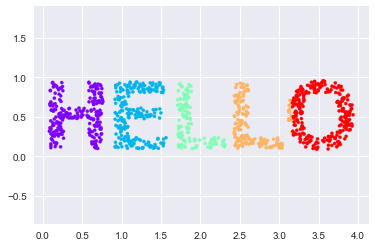

In [8]:
def make_hello(N=1000, rseed=42):
    # 画出‘HELLO’的形状
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold',size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], s=10, **colorize)
plt.axis('equal');

### 5.10.2　多维标度法（MDS）

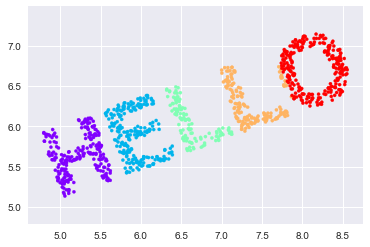

In [10]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], s=10, **colorize)
plt.axis('equal');

这说明 x 和 y 的值并不是数据间关系的必要基础特征。这个例子中真正的基础特征是每个
点与数据集中其他点的距离。表示这种关系的常用方法是关系（距离）矩阵：对于 N 个
点，构建一个 N × N 的矩阵，元素 (i , j ) 是点 i 和点 j 之间的距离。

In [12]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

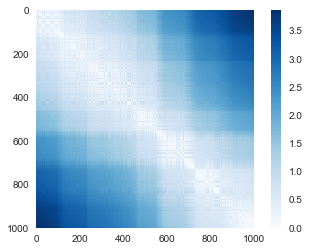

In [13]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

In [14]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

多维标度法可以解决的问题：它可以将一个数据集的距离矩阵还原成一个 D 维坐标来表示数据集。

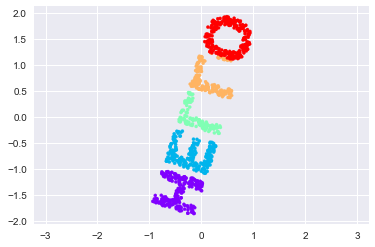

In [16]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], s=10, **colorize)
plt.axis('equal');

### 5.10.3　将MDS用于流形学习

In [17]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

X3 = random_projection(X, 3)
X3.shape

(1000, 3)

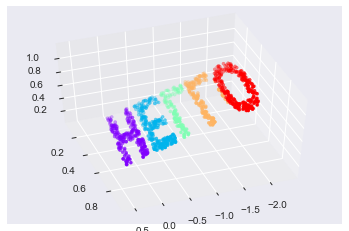

In [23]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X[:, 1], X3[:, 2], s=10, **colorize)
ax.view_init(azim=70, elev=50)

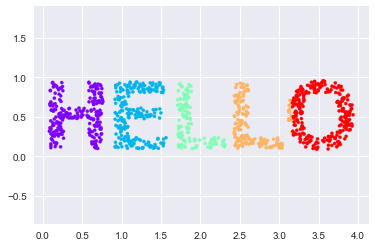

In [24]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit(X3)
plt.scatter(X[:, 0], X[:, 1], s=10, **colorize)
plt.axis('equal');

以上就是使用流形学习评估器希望达成的基本目标：给定一个高维嵌入数据，寻找数据的
一个低维表示，并保留数据间的特定关系。在 MDS 的示例中，保留的数据是每对数据点
之间的距离。

### 非线性嵌入：当MDS失败时

In [25]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)
XS.shape

(1000, 3)

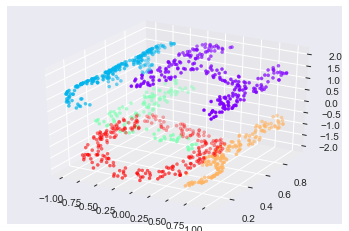

In [26]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter(XS[:, 0], XS[:, 1], XS[:, 2], s=10, **colorize);

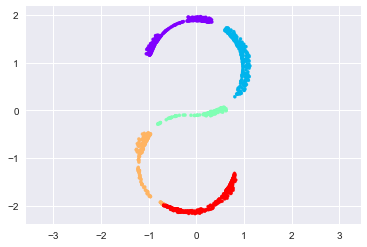

In [32]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], s=10, **colorize)
plt.axis('equal');

### 非线性流形：局部线性嵌入

MDS 算法构建嵌入时，总是期望保留相距很远的数据点之间的距离。但是如果修改算法，让它只保留比较接近的点之间的距离呢？

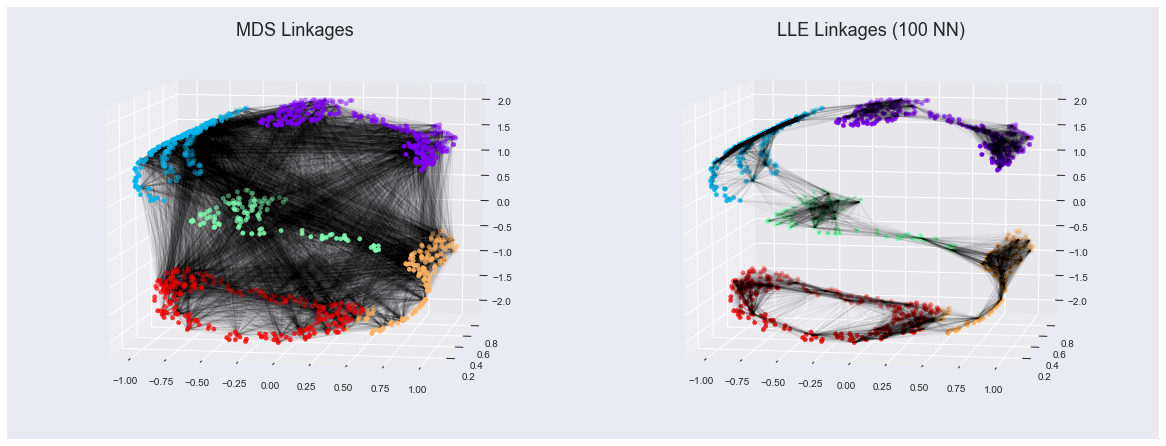

In [34]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from sklearn.neighbors import NearestNeighbors

# construct lines for MDS
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
lines_MDS = [(XS[i], XS[j]) for i in ind[:100] for j in ind[100:200]]

# construct lines for LLE
nbrs = NearestNeighbors(n_neighbors=100).fit(XS).kneighbors(XS[ind[:100]])[1]
lines_LLE = [(XS[ind[i]], XS[j]) for i in range(100) for j in nbrs[i]]
titles = ['MDS Linkages', 'LLE Linkages (100 NN)']

# plot the results
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(projection='3d'))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)

for axi, title, lines in zip(ax, titles, [lines_MDS, lines_LLE]):
    axi.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);
    axi.add_collection(Line3DCollection(lines, lw=1, color='black',
                                        alpha=0.05))
    axi.view_init(elev=10, azim=-80)
    axi.set_title(title, size=18)

fig.savefig('figures/05.10-LLE-vs-MDS.png')

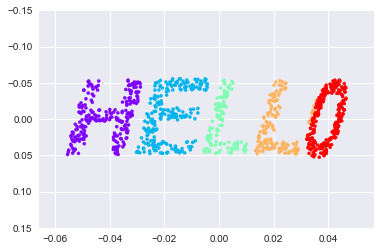

In [37]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2,method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], s=10, **colorize)
ax.set_ylim(0.15, -0.15);

### 示例：手写数字的可视化结构